# VGG

In [1]:
# torch
import torch 
import torch.nn as nn
import torch.optim as optim  
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.transforms import Compose, ToTensor, Resize
from torchvision.datasets import ImageFolder
from torch.utils.data import (
    Dataset,
    DataLoader,
    Subset
) 

# other
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import warnings
from skimage import io
import time
import copy
import cv2
from tqdm import tqdm

warnings.filterwarnings("ignore")

# helper functions
from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix, compute_accuracy, cal_pre_rec
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset import UnNormalize
from data_loading_functions import split_train_test_loaders, show_img, convert_lab
from helper_Gradcam import store_gradcam_image

# Settings

In [2]:
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0005
BATCH_SIZE = 64
NUM_EPOCHS = 20

# Architecture
NUM_FEATURES = 224*224
NUM_CLASSES = 4

# Other
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GRAYSCALE = False

# Load Data and Preprocessing 

In [3]:
dataset_path = '.\\COVID-19_Radiography_Dataset'
datas, train_loader, valid_loader, test_loader = split_train_test_loaders(dataset_path, batch_size= BATCH_SIZE)

# Display Images

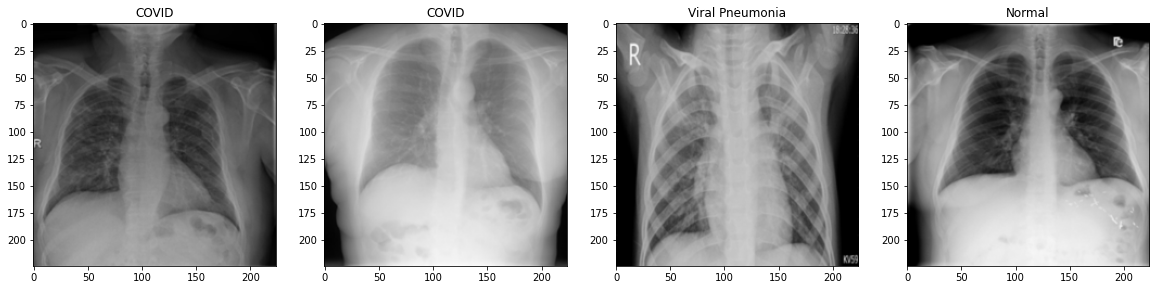

In [29]:
show_img(dataset_path= dataset_path, train= False)

In [4]:
model_ft = torchvision.models.vgg19_bn(pretrained=True)
model_ft

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

# Train Model

In [6]:
# load pretrained models
model_ft = torchvision.models.vgg19_bn(pretrained=True)

# freeze param for feature layer
for name, child in model_ft.named_children():
    if name in ['classifier']:
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False


# unfreeze last 3 conv layer's grad
for param in model_ft.features[43:].parameters():
    param.requires_grad = True


# change out_features of last linear layer
model_ft.classifier[6] = nn.Linear(in_features=4096, out_features=4, bias=True)               


# Train
torch.manual_seed(RANDOM_SEED)
model_ft.to(DEVICE)
optimizer = torch.optim.Adam(model_ft.parameters(), lr=LEARNING_RATE)  

minibatch_loss_list_ft, train_acc_list_ft, valid_acc_list_ft = train_model(num_epochs = NUM_EPOCHS, model = model_ft, 
                                                                optimizer = optimizer, device = DEVICE, 
                                                                train_loader = train_loader, valid_loader=valid_loader, 
                                                                test_loader = test_loader, logging_interval=50)

Epoch: 001/020 | Batch 0000/0265 | Loss: 1.4288
Epoch: 001/020 | Batch 0050/0265 | Loss: 0.3214
Epoch: 001/020 | Batch 0100/0265 | Loss: 0.5002
Epoch: 001/020 | Batch 0150/0265 | Loss: 0.2499
Epoch: 001/020 | Batch 0200/0265 | Loss: 0.5306
Epoch: 001/020 | Batch 0250/0265 | Loss: 0.1269
Epoch: 001/020 | Train: 90.89% | Validation: 89.66%
Time elapsed: 3.45 min
Epoch: 002/020 | Batch 0000/0265 | Loss: 0.2592
Epoch: 002/020 | Batch 0050/0265 | Loss: 0.1900
Epoch: 002/020 | Batch 0100/0265 | Loss: 0.3259
Epoch: 002/020 | Batch 0150/0265 | Loss: 0.2943
Epoch: 002/020 | Batch 0200/0265 | Loss: 0.3944
Epoch: 002/020 | Batch 0250/0265 | Loss: 0.2184
Epoch: 002/020 | Train: 93.96% | Validation: 92.25%
Time elapsed: 6.85 min
Epoch: 003/020 | Batch 0000/0265 | Loss: 0.2156
Epoch: 003/020 | Batch 0050/0265 | Loss: 0.2503
Epoch: 003/020 | Batch 0100/0265 | Loss: 0.2994
Epoch: 003/020 | Batch 0150/0265 | Loss: 0.1490
Epoch: 003/020 | Batch 0200/0265 | Loss: 0.3025
Epoch: 003/020 | Batch 0250/0265 |

In [7]:
torch.save(model_ft, os.path.join('.\\models', 'VGG19bn_oldnorm.pth'))

# Evaluation 

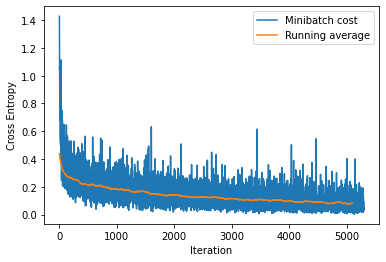

In [8]:
plt.plot(minibatch_loss_list_ft, label='Minibatch cost')
plt.plot(np.convolve(minibatch_loss_list_ft, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

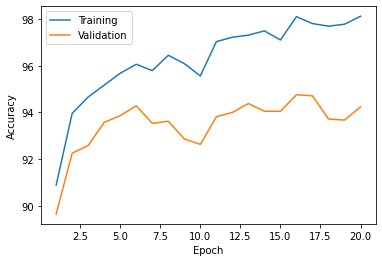

In [9]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list_ft, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list_ft, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

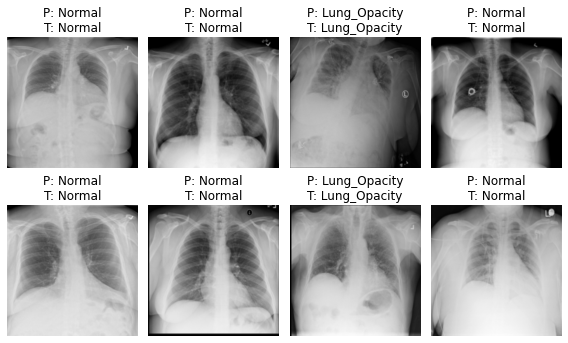

In [11]:
model_ft.cpu()
unnormalizer = UnNormalize((0.4363, 0.4328, 0.3291), (0.2129, 0.2075, 0.2038))
class_dict  = {0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}

show_examples(model=model_ft, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)

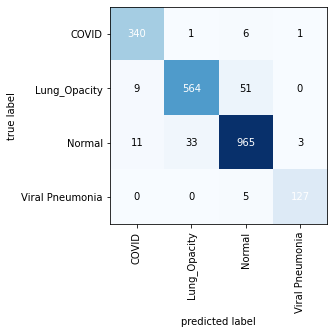

In [10]:
model_ft = torch.load(os.path.join('.\\models', 'VGG19bn_oldnorm.pth'))
model_ft.cpu()
model_ft.to(DEVICE)
class_dict  = {0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}

mat = compute_confusion_matrix(model=model_ft, data_loader=test_loader, device=DEVICE)
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

# Compute Acc


In [5]:
cal_pre_rec(mat)

COVID => Precision: 97.7%, Recall: 94.44%, F1: 96.05%
-----------------
Lung_Opacity => Precision: 90.38%, Recall: 94.31%, F1: 92.31%
-----------------
Normal => Precision: 95.36%, Recall: 93.96%, F1: 94.65%
-----------------
Viral Pneumonia => Precision: 96.21%, Recall: 96.95%, F1: 96.58%
-----------------


# Grad Cam

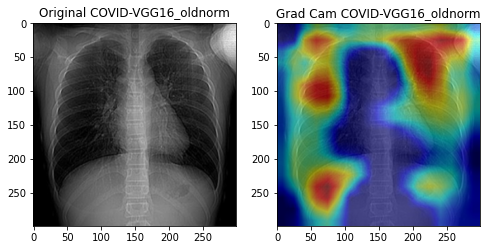

In [11]:
model_ft = torch.load(os.path.join('.\\models', 'VGG19bn_oldnorm.pth'))
model_ft.to(DEVICE)

# get gradients
for param in model_ft.features.parameters():
    param.requires_grad = True

# Parameters 
feature_module = model_ft.features ## Don't need to change this
target_layer = ['51'] 
model_name = 'VGG16_oldnorm' ## Name for your plt title
class_name = 'COVID' 
index = 121

store_gradcam_image(model_ft, feature_module, target_layer, model_name, class_name, index)